In [8]:
from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.12.0


In [9]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print(f"Train shape: {train_images.shape}")
    print(f"Test shape: {test_images.shape}")
    return train_images, train_labels, test_images, test_labels, class_names

train_images, train_labels, test_images, test_labels, class_names = load_data()

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


In [10]:
def preprocess_data(train_images, test_images):
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    return train_images, test_images

train_images, test_images = preprocess_data(train_images, test_images)

In [11]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [12]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr / 2
    return lr


def k_fold_cross_validation(k, train_images, train_labels, learning_rate, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    num_val_samples = len(train_images) // k
    all_scores = []
    all_loss = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [train_images[:i * num_val_samples],
            train_images[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_labels[:i * num_val_samples],
            train_labels[(i + 1) * num_val_samples:]],
            axis=0)
        model = create_model()
        # use optimizer based on the input
        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        model.compile(optimizer=opt,
                    loss=loss,
                    metrics=metrics)
        model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=batch_size, verbose=verbose, callbacks=[callback])
        val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_acc)
        all_loss.append(val_loss)
    return all_scores, all_loss



def plot_k_fold_cross_validation(all_scores):
    # bar chart of accuracy
    min = np.min(all_scores)
    max = np.max(all_scores)
    delta = max - min
    plt.bar(range(len(all_scores)), all_scores)
    plt.title('Accuracy Scores')
    plt.xlabel('Folds')
    plt.ylabel('Accuracy')
    plt.ylim(min - delta * 0.1, max + delta * 0.1)
    plt.xticks(range(len(all_scores)))
    plt.show()
    # boxplot
    sns.boxplot(all_scores)
    plt.title('Accuracy Scores')
    plt.xlabel('10 folds')
    plt.ylabel('Accuracy')
    # no ticks
    plt.xticks([])
    plt.show()


def plot_k_fold_cross_validation_loss(all_loss):
    min = np.min(all_loss)
    max = np.max(all_loss)
    delta = max - min
    plt.bar(range(len(all_loss)), all_loss)
    plt.title('Loss Scores')
    plt.xlabel('Folds')
    plt.ylabel('Loss')
    plt.ylim(min - delta * 0.1, max + delta * 0.1)
    plt.xticks(range(len(all_loss)))
    plt.show()

In [13]:

all_scores, all_loss = k_fold_cross_validation(10, train_images, train_labels, learning_rate=0.001, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


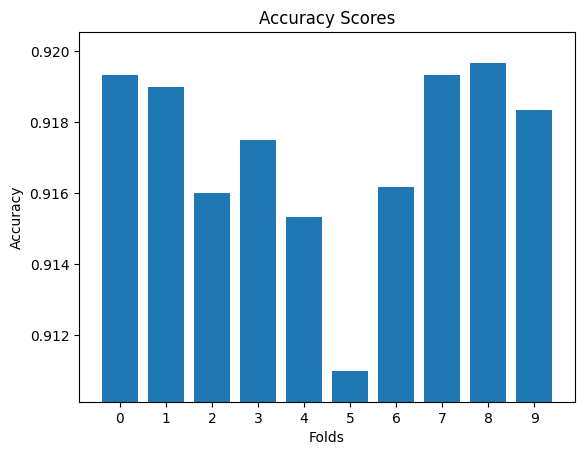

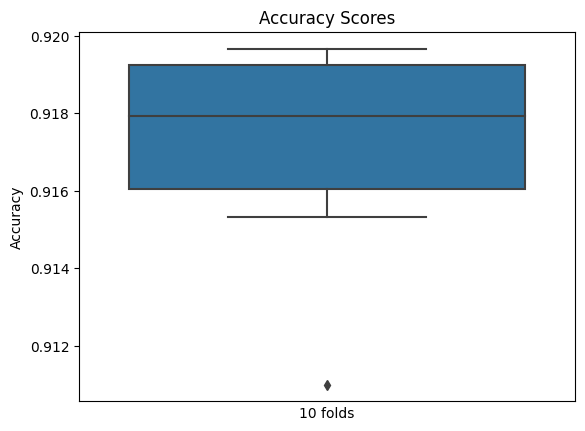

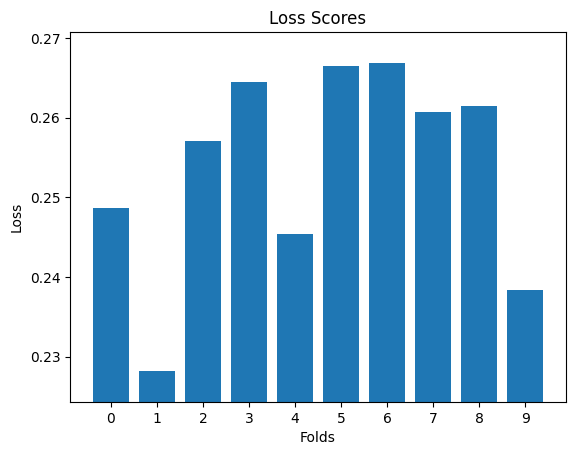

In [14]:
plot_k_fold_cross_validation(all_scores)
plot_k_fold_cross_validation_loss(all_loss)

In [20]:
model = create_model()

# Train the model
def train_model(train_images, train_labels , model):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=15, batch_size=64, callbacks=[callback])
    return model, history

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

Epoch 1/15
938/938 [==============================] - 18s 19ms/step - loss: 0.5513 - accuracy: 0.7973 - val_loss: 0.3995 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 18s 19ms/step - loss: 0.3489 - accuracy: 0.8726 - val_loss: 0.3467 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 19s 20ms/step - loss: 0.3001 - accuracy: 0.8897 - val_loss: 0.3013 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 18s 19ms/step - loss: 0.2688 - accuracy: 0.9019 - val_loss: 0.2989 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 18s 19ms/step - loss: 0.2444 - accuracy: 0.9107 - val_loss: 0.2951 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 18s 19ms/step - loss: 0.2055 - accuracy: 0.9240 - val_loss: 0.2521 - val_accuracy: 0.9108 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 

In [21]:
# plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
history.history

{'loss': [0.5512571334838867,
  0.3488564193248749,
  0.30011874437332153,
  0.26881980895996094,
  0.2443724125623703,
  0.2055334597826004,
  0.19171138107776642,
  0.18083783984184265,
  0.1706175059080124,
  0.1596282571554184,
  0.13674235343933105,
  0.12959522008895874,
  0.12401874363422394,
  0.11793629825115204,
  0.11256452649831772],
 'accuracy': [0.7972666621208191,
  0.8725500106811523,
  0.8897166848182678,
  0.9019166827201843,
  0.9106666445732117,
  0.924049973487854,
  0.9286666512489319,
  0.9334166646003723,
  0.9369166493415833,
  0.9407833218574524,
  0.9500166773796082,
  0.9526666402816772,
  0.955049991607666,
  0.9571166634559631,
  0.9595500230789185],
 'val_loss': [0.3994921147823334,
  0.3466516435146332,
  0.30131831765174866,
  0.29893752932548523,
  0.2950916886329651,
  0.25213736295700073,
  0.26109591126441956,
  0.25284790992736816,
  0.24942563474178314,
  0.2504442632198334,
  0.24588969349861145,
  0.24968920648097992,
  0.2523229122161865,
  0.2

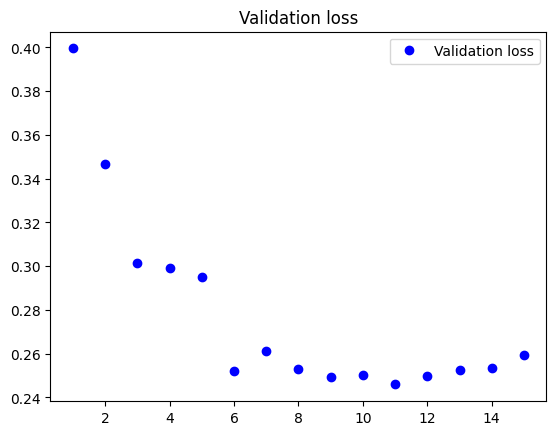

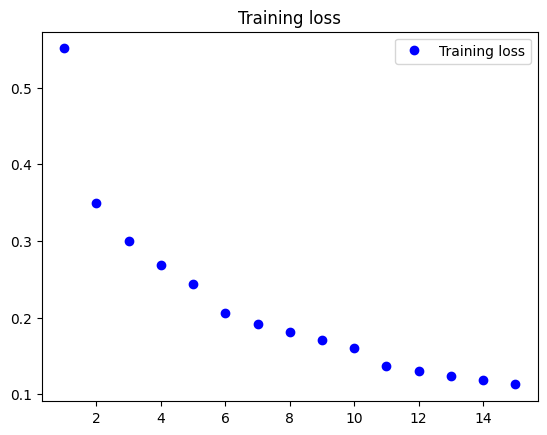

In [23]:
# plot loss and accuracy
def plot_loss_and_accuracy(history):
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, 'bo', label='Validation loss')
    plt.title('Validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

plot_loss_and_accuracy(history)

Epoch 1/15
938/938 [==============================] - 21s 21ms/step - loss: 0.5464 - accuracy: 0.7972 - val_loss: 0.4109 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 20s 21ms/step - loss: 0.3507 - accuracy: 0.8719 - val_loss: 0.3481 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 20s 21ms/step - loss: 0.3052 - accuracy: 0.8895 - val_loss: 0.3080 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 20s 21ms/step - loss: 0.2713 - accuracy: 0.9009 - val_loss: 0.2893 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 20s 21ms/step - loss: 0.2536 - accuracy: 0.9069 - val_loss: 0.2727 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 20s 21ms/step - loss: 0.2171 - accuracy: 0.9198 - val_loss: 0.2534 - val_accuracy: 0.9088 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 

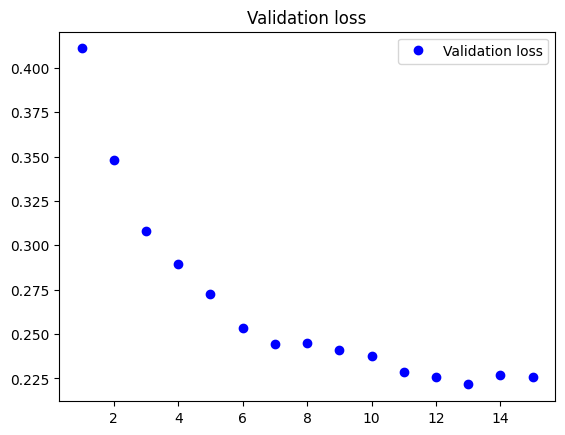

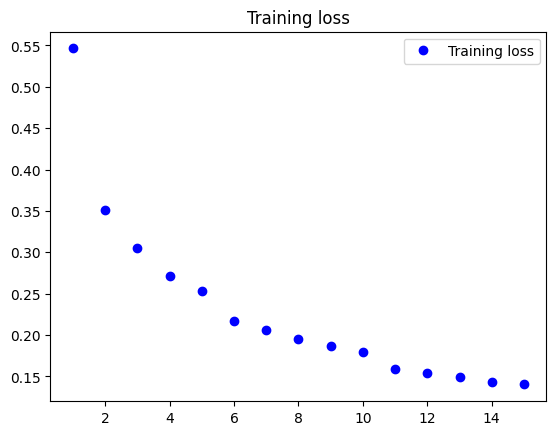

In [24]:
#Dropout inclussion after second maxpooling
#Dropout prevents overfitting by dropping a random weight (.5= 50% chance to happen)
#Dropout reduces correlation between neurons. It is added after second convolution layer before maxpolling since overfitting is most likely to happen there
def create_model_variant1():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model_variant1()

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: Dropout variant is both better than baseline on the test data and train data. A clear sign that the base model is slightly overfit.
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.2319 - accuracy: 0.9158 Variant1

Epoch 1/15
938/938 [==============================] - 17s 17ms/step - loss: 1.0455 - accuracy: 0.7962 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 17s 18ms/step - loss: 0.5840 - accuracy: 0.8601 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 19s 20ms/step - loss: 0.4965 - accuracy: 0.8754 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 20s 22ms/step - loss: 0.4500 - accuracy: 0.8836 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 18s 19ms/step - loss: 0.4179 - accuracy: 0.8884 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 17s 18ms/step - loss: 0.3668 - accuracy: 0.9031 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 21s 23ms/step - loss: 0.3522 - accuracy: 0.9042 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 19s 21ms/step - loss: 0.3410 - accuracy: 0.9076 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 21s 22ms/step 

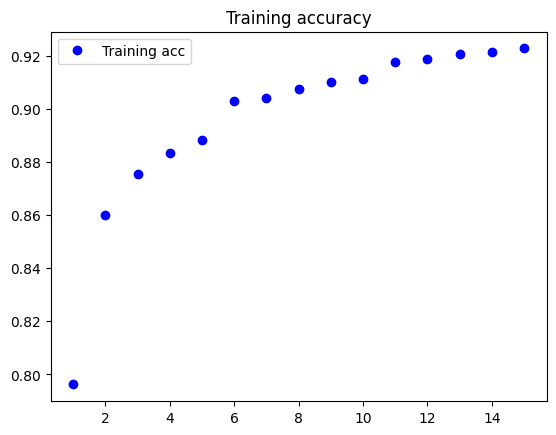

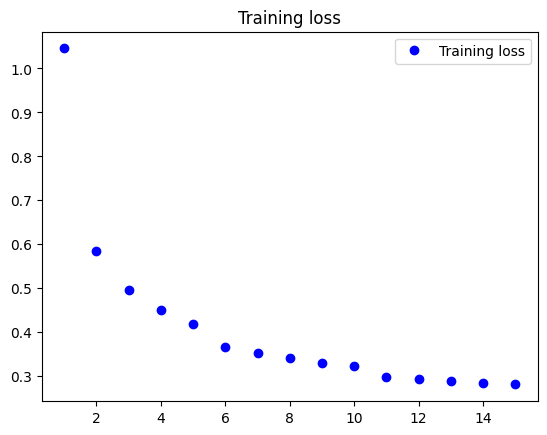

In [18]:
#L1 Regularization: Added to dense layers
#L1 prevents overfitting by making the model use more weights that are set to 0
def create_model_variant2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)),
        tf.keras.layers.Dense(10, activation='softmax' , kernel_regularizer=tf.keras.regularizers.l1(0.001))
    ])
    return model

model = create_model_variant2()

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: L1 performs better on the train data but has higher loss. This means its underfitting and will need more epochs to converge.
# In the test data it performs a bit worse than baseline.
# Different value for the strength could improve the results. In short it underfits compared to the baseline. Can't coverge fast enough in 15 epochs.
#Conclussion: loloss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.3358 - accuracy: 0.9046 Variant2

Epoch 1/15
938/938 [==============================] - 21s 21ms/step - loss: 0.4263 - accuracy: 0.8454 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 20s 22ms/step - loss: 0.2928 - accuracy: 0.8936 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 19s 21ms/step - loss: 0.2521 - accuracy: 0.9070 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 20s 21ms/step - loss: 0.2244 - accuracy: 0.9168 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 20s 22ms/step - loss: 0.2024 - accuracy: 0.9262 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 20s 21ms/step - loss: 0.1503 - accuracy: 0.9439 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 20s 21ms/step - loss: 0.1312 - accuracy: 0.9517 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 25s 27ms/step - loss: 0.1169 - accuracy: 0.9567 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 22s 23ms/step 

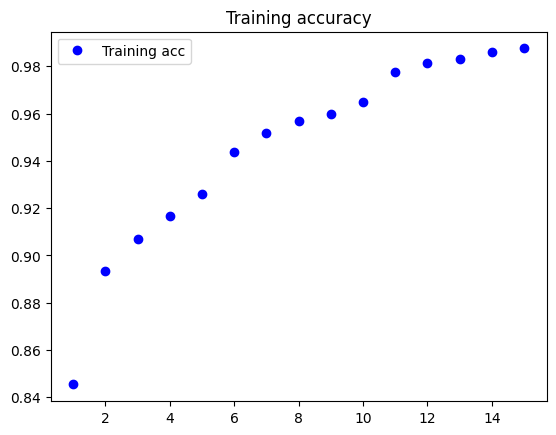

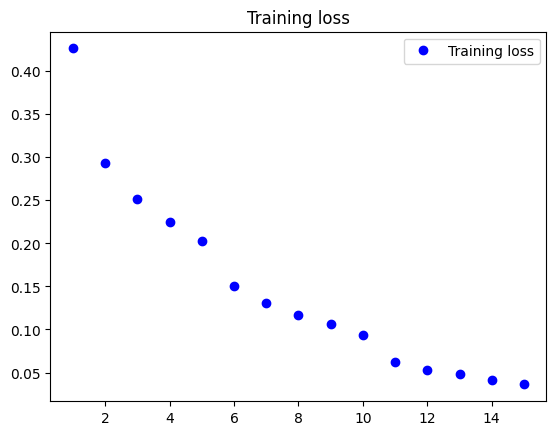

In [16]:
#Batch normalization: After first Conv2D layer 
#Stabilize learning process. Normalizes values to 0 or to 1 depending on whichever they are closer to using mean and std, solves internal covariate shift.
def create_model_variant3():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model_variant3()

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: Batch normalization trains excelently BUT will need more epochs to improve validation accuracy. Seems to overfit.
#This variant could also largely improve by adding a dropping layer and regulizers to reduce overfitting (but we can only have 1 change per variant).
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.4109 - accuracy: 0.9140 Variant3

Epoch 1/15
938/938 [==============================] - 17s 17ms/step - loss: 0.6123 - accuracy: 0.8045 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 16s 17ms/step - loss: 0.4031 - accuracy: 0.8762 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 16s 17ms/step - loss: 0.3510 - accuracy: 0.8904 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 16s 17ms/step - loss: 0.3196 - accuracy: 0.9003 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 20s 21ms/step - loss: 0.2972 - accuracy: 0.9063 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 18s 19ms/step - loss: 0.2593 - accuracy: 0.9196 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 16s 17ms/step - loss: 0.2479 - accuracy: 0.9226 - lr: 5.0000e-04
Epoch 8/15
938/938 [==============================] - 16s 17ms/step - loss: 0.2398 - accuracy: 0.9258 - lr: 5.0000e-04
Epoch 9/15
938/938 [==============================] - 16s 17ms/step 

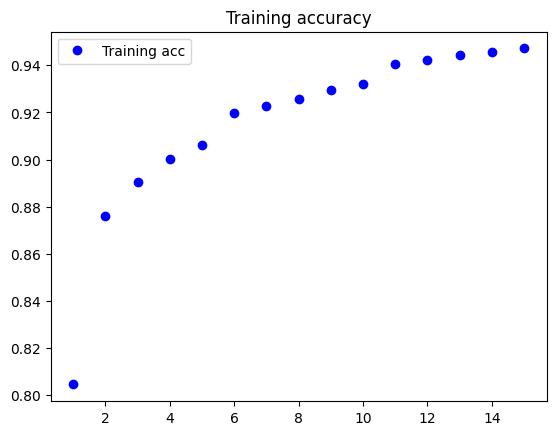

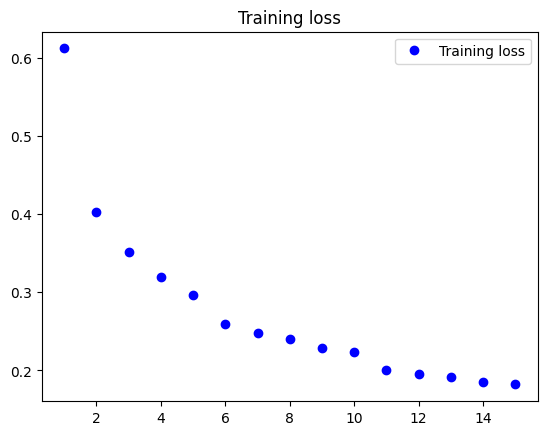

In [17]:
#L2 Regularization: Adding to dense layers
#L2 prevents overfitting by slowly melting large weight values, encourages model to use lower weights
def create_model_variant4():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    return model

model = create_model_variant4()

model, history = train_model(train_images, train_labels, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: L2 variant is a lot better than baseline on the train data but the accuracy seems better on the test data.
# It seems to converge faster however also appears to overfit since loss is higher on the test data.
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.2698 - accuracy: 0.9173 Variant4